# Spam Classification Using Feature Engineering Method
Wan Nazirul Hafeez, March 2018
### My goal is to predict if a new sms is spam or non-spam. I assume that is much worse misclassify non-spam than misclassify an spam. (I don't want to have false positives)

The reason is because I normally don't check the spam messages.
The two possible situations are:
New spam sms in my inbox. (False negative).
OUTCOME: I delete it.
New non-spam sms in my spam folder (False positive).
OUTCOME: I probably don't read it.

I prefer the first option!!!

Type II error!

http://sanjaymeena.io/tech/spam_deep_learning/

# 1. Import libraries

In [3]:

import pandas as pd
import numpy as np
from matplotlib import style
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import display, HTML
import itertools

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 2. Import Data

In [4]:
#Lesson 3: Load Data From CSV
data = pd.read_csv('E:\Git\_DL\smsORI2.csv')
data.head(5)

,Class,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.Class.value_counts()

ham     4827
spam     747
Name: Class, dtype: int64

In [7]:
pd.DataFrame(data=data.sum().isnull(), columns=["Has null?"])

,Has null?
Class,False
SMS,False


# 3. Preprocessing
- Features: No. character & no. words

#### Alt 2

In [8]:
sms = data
sms.columns = ['class','message']
sms["no_letters"] = sms["message"].apply(lambda x: len(x))
sms["no_words"] = sms["message"].apply(lambda x: len(str(x).split(' ' )))
sms["no_spaces"] = sms["message"].apply(lambda x: sum( l == " " for l in str(x)))
sms["no_alnum"] = sms["message"].apply(lambda x: sum( l.isalnum() for l in str(x)))
sms["no_notalnum"] = sms["message"].apply(lambda x: sum( not l.isalnum() for l in str(x)))
sms["no_alnum"] = sms["message"].apply(lambda x: sum( l.isalnum() for l in str(x)))
sms["no_digits"] = sms["message"].apply(lambda x: sum( l.isdigit() for l in str(x)))
sms["no_capital"] = sms["message"].apply(lambda x: sum (l.isupper() for l in str(x)))
sms["no_unique"] = sms["message"].apply(lambda x: len(set(str(x).split(' '))))
sms["no_punct"] = sms["message"].apply(lambda x: sum(str(x).count(punct) for punct in ".,:;" ))
sms["no_excl"] = sms["message"].apply(lambda x: sum(str(x).count(punct) for punct in "!" ))
sms["no_quest"] = sms["message"].apply(lambda x: sum(str(x).count(punct) for punct in "?" ))

# For some models the target label has to be int, float or bool
sms['class'] = (sms['class'] == 'spam')

In [6]:
sms.head(4)

,class,message,no_letters,no_words,no_spaces,no_alnum,no_notalnum,no_digits,no_capital,no_unique,no_punct,no_excl,no_quest
0,False,"Go until jurong point, crazy.. Available only ...",111,20,19,83,28,0,3,20,9,0,0
1,False,Ok lar... Joking wif u oni...,29,6,5,18,11,0,2,6,6,0,0
2,True,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,27,122,33,25,10,24,1,0,0
3,False,U dun say so early hor... U c already then say...,49,11,10,33,16,0,2,10,6,0,0


# 4. Exploratory analysis

#### Correlation Map
From those new features we created, we would like to see what is the relevant attributes relative to the ham/spam class by using correlation values.

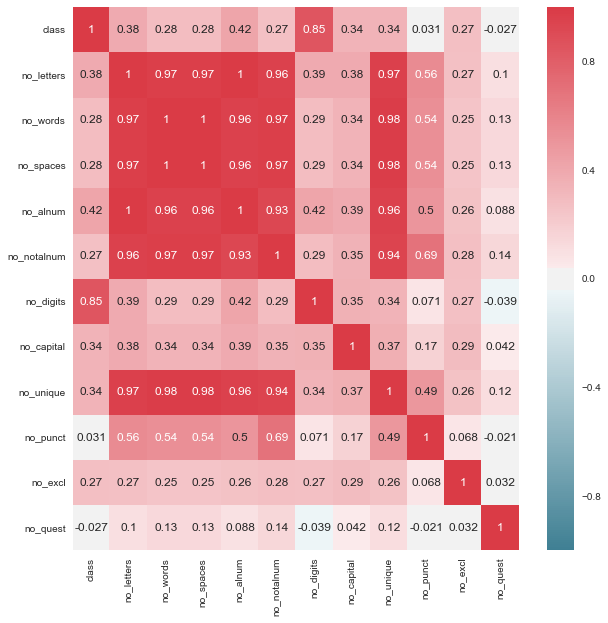

In [10]:
sms_corr = sms.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(sms_corr, cmap=cmap, annot=True)
plt.show()

From the correlation map above, we can see that *number of digit* in particular message having high positive correlation with the class label followed by *number of alphanumeric* and *number of letters* while *number of punctuation* and *number of question* mark are lossly correlated.

Therefore these three attributes might be our picked for features selection later on.

#### Attributes Distribution 
Next we will plot the normalized histogram of highly and lossely correlated attributes base from the correlation map above.
- Number of letters
- Number of alphanumeric
- Number of digits
- Number of punctuation

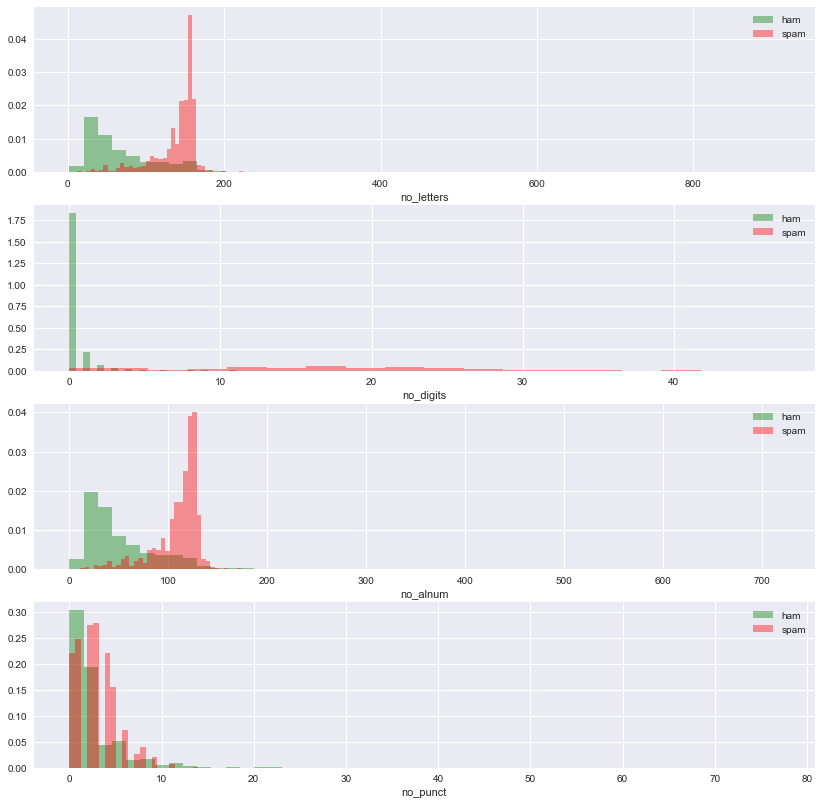

In [7]:
fig, ax = plt.subplots(4,1, figsize=(14, 14))

sns.distplot(sms[sms["class"] == 0]["no_letters"], color="green", label="ham", norm_hist=True, kde=False, ax=ax[0])
sns.distplot(sms[sms["class"] == 1]["no_letters"], color="red", label="spam", norm_hist=True, kde=False, ax=ax[0])
ax[0].legend()

sns.distplot(sms[sms["class"] == 0]["no_digits"], color="green", label="ham", norm_hist=True, kde=False, ax=ax[1])
sns.distplot(sms[sms["class"] == 1]["no_digits"], color="red", label="spam", norm_hist=True, kde=False, ax=ax[1])
ax[1].legend()

sns.distplot(sms[sms["class"] == 0]["no_alnum"], color="green", label="ham", norm_hist=True, kde=False, ax=ax[2])
sns.distplot(sms[sms["class"] == 1]["no_alnum"], color="red", label="spam", norm_hist=True, kde=False, ax=ax[2])
ax[2].legend()

sns.distplot(sms[sms["class"] == 0]["no_punct"], color="green", label="ham", norm_hist=True, kde=False, ax=ax[3])
sns.distplot(sms[sms["class"] == 1]["no_punct"], color="red", label="spam", norm_hist=True, kde=False, ax=ax[3])
ax[3].legend()

plt.show()

Top 3 vs 1

#### Word Cloud

Next, we would like to visualize which word features the most and frequent for both ham & spam message by using word cloud.

In [9]:
ham_words = ''
spam_words = ''
spam = sms[sms["class"] == 1]
ham = sms[sms["class"] == 0]

ham_messages_train = pd.Series(sms[sms['class'] == 0]['message'].tolist()).astype(str)
spam_messages_train = pd.Series(sms[sms['class'] == 1]['message'].tolist()).astype(str)

ham_messages_train.head(5)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    U dun say so early hor... U c already then say...
3    Nah I don't think he goes to usf, he lives aro...
4    Even my brother is not like to speak with me. ...
dtype: object

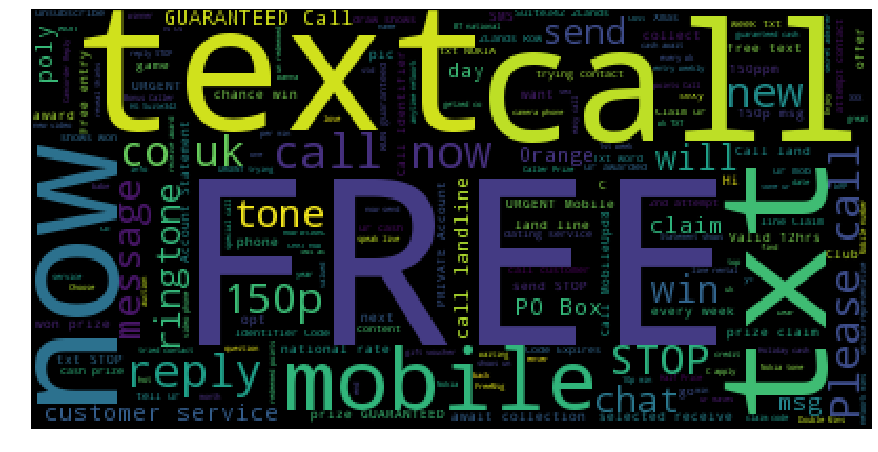

In [10]:
from wordcloud import WordCloud
# WordCloud automatically excludes stop words

# Draw word cloud for spam messages
spam_messages_one_string = " ".join(spam_messages_train.astype(str))
spam_cloud = WordCloud().generate(spam_messages_one_string)
plt.figure(figsize=(12,8))
plt.imshow(spam_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

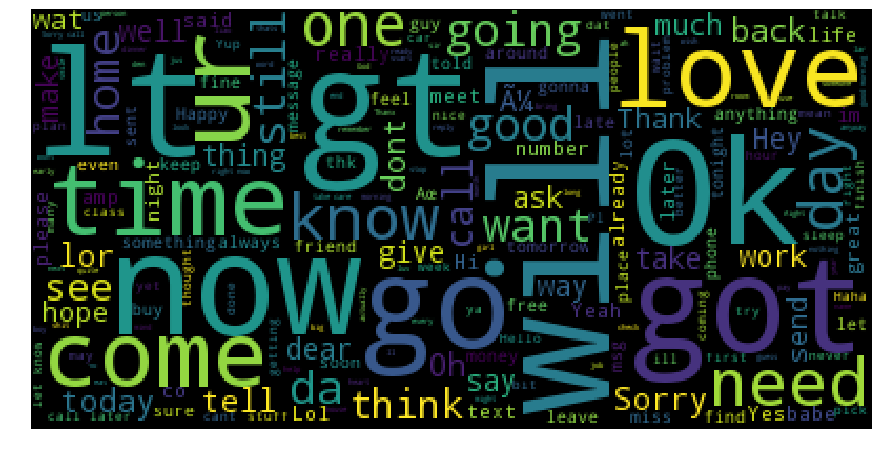

In [11]:
# Draw word cloud for ham messages
ham_messages_one_string = " ".join(ham_messages_train.astype(str))
ham_cloud = WordCloud().generate(ham_messages_one_string)
plt.figure(figsize=(12,8))
plt.imshow(ham_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

As you might expect, spam messages frequently include words such as FREE, now, mobile, call, text, and txt. The words used frequently in ham messages seem more general, e.g. Ok, ur. We can see that messages like 'got to go' and 'will ...' also seem common, which is intuitive.

It's odd why the words lt and gt are so common. I'm not aware that people often abbreviate e.g. later as lt and get as gt. To me they seem like abbreviations for less than and greater than.

Now is common in both ham and spam messages, so checking whether that word is in a message probably won't be too effective in distinguishing between the two.

# 4. Classification Modelling using Features 
### Train Test split dataset

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [13]:
from sklearn.model_selection import train_test_split
rs = 111
c_to_keep = ["no_letters", "no_digits", "no_alnum"]
X_train, X_test, y_train, y_test = train_test_split(sms[c_to_keep], sms["class"], 
                                                    test_size=0.2, train_size=0.8, 
                                                    random_state=rs)

#### SVM

In [14]:
svm = SVC()
svm.fit(X_train,y_train)
svmprediction = svm.predict(X_test)
print('Accuracy of svm for Training is: ',svm.score(X_train,y_train))

Accuracy of svm for Training is:  0.989908051133


In [15]:
cmSVM = confusion_matrix(y_test, svmprediction)

print('Classification Report')
print(classification_report(y_test, svmprediction))

Classification Report
             precision    recall  f1-score   support

      False       0.95      1.00      0.97       971
       True       0.98      0.65      0.78       144

avg / total       0.95      0.95      0.95      1115



#### KNN

In [16]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,y_train)
knnprediction = knn.predict(X_test)
print('Accuracy of KNN with (K=3) for Training is: ',knn.score(X_train,y_train))

Accuracy of KNN with (K=3) for Training is:  0.983404350751


In [17]:
cmKNN = confusion_matrix(y_test, knnprediction)

print('Classification Report')
print(classification_report(y_test, knnprediction))

Classification Report
             precision    recall  f1-score   support

      False       0.98      1.00      0.99       971
       True       0.97      0.88      0.92       144

avg / total       0.98      0.98      0.98      1115



#### Random Forest

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rfprediction = rf.predict(X_test)
print('Accuracy of RF for Training is: ',rf.score(X_train,y_train))

Accuracy of RF for Training is:  0.99416909621


In [1]:
cmRF = confusion_matrix(y_test, rfprediction)

print('Classification Report')
print(classification_report(y_test, rfprediction))

NameError: name 'confusion_matrix' is not defined

# 5. Performance Measurement

#### Confusion Matrix

In [19]:
#Declare neccessary function for confusion matrix
y = np.array(sms['class'])
class_names = np.unique(y)
np.set_printoptions(precision=2)

#Function for plotting
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

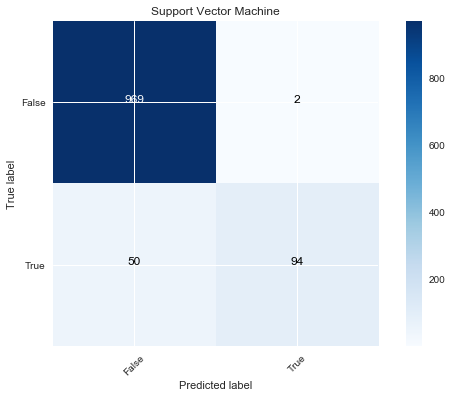

Number of SVM misclassified legitimate SMS as Spam:
2
Accuracy of svm for Testing is:  0.9533632287


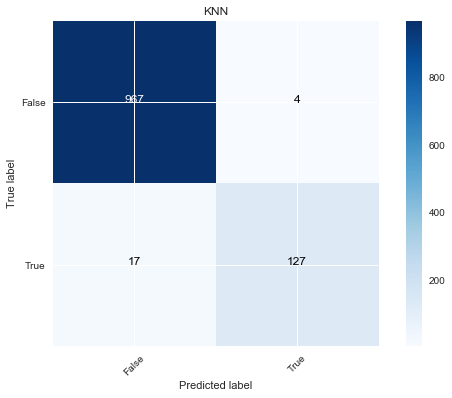

Number of KNN misclassified legitimate SMS as Spam:
4
Accuracy of KNN with (K=3) for Testing is:  0.981165919283


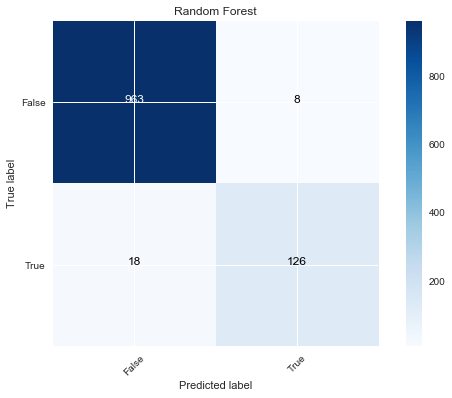

Number of RF misclassified legitimate SMS as Spam:
8
Accuracy of RF for Testing is:  0.97668161435


In [25]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cmSVM, classes=class_names,
                      title='Support Vector Machine')
plt.show()
FP = cmSVM[0][1]
print('Number of SVM misclassified legitimate SMS as Spam:')
print(FP)
print('Accuracy of svm for Testing is: ',svm.score(X_test,y_test))

plot_confusion_matrix(cmKNN, classes=class_names,
                      title='KNN')
plt.show()
FP = cmKNN[0][1]
print('Number of KNN misclassified legitimate SMS as Spam:')
print(FP)
print('Accuracy of KNN with (K=3) for Testing is: ',knn.score(X_test,y_test))

plot_confusion_matrix(cmRF, classes=class_names,
                      title='Random Forest')
plt.show()
FP = cmRF[0][1]
print('Number of RF misclassified legitimate SMS as Spam:')
print(FP)
print('Accuracy of RF for Testing is: ',rf.score(X_test,y_test))

In [20]:
X_test[y_test < svmprediction ]

,no_letters,no_digits,no_alnum
4330,154,6,116
4056,180,0,142


In [21]:
print(sms.iloc[4330].message)
print(sms.iloc[2859].message)

1Apple/Day=No Doctor. 1Tulsi Leaf/Day=No Cancer. 1Lemon/Day=No Fat. 1Cup Milk/day=No Bone Problms 3 Litres Watr/Day=No Diseases Snd ths 2 Whom U Care..:-)
In life when you face choices Just toss a coin not becoz its settle the question But while the coin in the air U will know what your heart is hoping for. Gudni8


# 6. Conclusion

In this experiment, we show the desriptive analytics during the EDA section and compare the relationship of numerical attributes in Linear Regression / Scatter Plot. We also performed the predictive analytics on the classification of Students Academic Performance and we able to show that all algorithms performs well in correctly classified the High / Medium / Low level class numerical intervals based on their total grade/mark.

In [1]:
import keras

from keras.layers import Input, Dense
from keras.models import Model,load_model
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [2]:
# max number of features
num_max = 4000